<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-12 15:11:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-08-12 15:11:27 (270 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



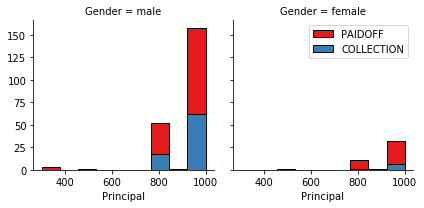

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

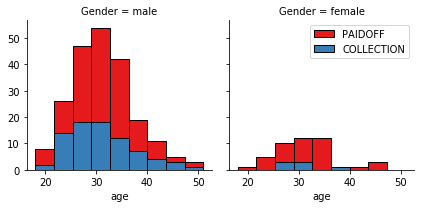

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

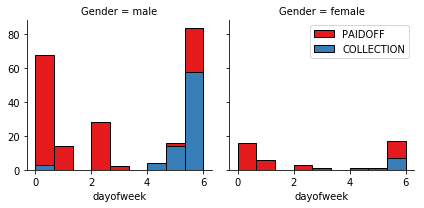

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [20]:
from sklearn.model_selection import train_test_split

#Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [21]:
# Evaluation Metrices
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Trying different k values to determine best k option
score_list = []
for each in range(1,10):
    knn = KNeighborsClassifier(n_neighbors = each)
    knn.fit(x_train, y_train)
    score_list.append(knn.score(x_test,y_test))

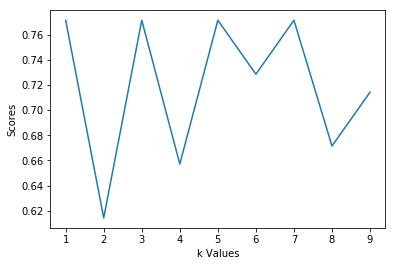

In [23]:
#Plotting k Values vs Scores
plt.plot(range(1,10),score_list)
plt.xlabel("k Values")
plt.ylabel("Scores")
plt.show()

### As it can be seen that score is nearly max when k = 7

In [24]:
# Model with best accuracy
knn2 = KNeighborsClassifier(n_neighbors = 7)
knn2.fit(x_train, y_train)
y_head = knn2.predict(x_test)
print("KNN Best F1 Score: ",f1_score(y_test, y_head, average = 'weighted'))
print("KNN Best Jaccard Score: ",jaccard_similarity_score(y_test, y_head))

KNN Best F1 Score:  0.7333333333333333
KNN Best Jaccard Score:  0.7714285714285715


# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_similarity_score, f1_score

#Score observation for best max_depth value choice
jaccard_score = []
f1_score_ = []

for dep in range(1,10):
    tc = DecisionTreeClassifier(criterion = "gini", max_depth = dep)
    tc.fit(x_train, y_train)
    y_head = tc.predict(x_test) 
    jaccard_score.append(jaccard_similarity_score(y_test, y_head))
    f1_score_.append(f1_score(y_test,y_head, average = 'weighted'))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


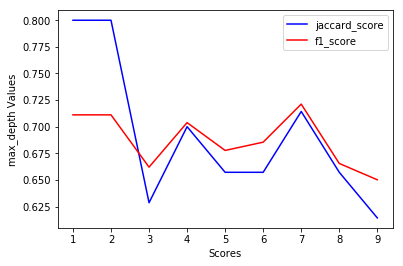

In [26]:
#Plotting max_depth Values vs Scores
plt.plot(range(1,10), jaccard_score, c = 'blue', label = "jaccard_score")
plt.plot(range(1,10), f1_score_, c = 'red', label = "f1_score")
plt.xlabel("Scores")
plt.ylabel("max_depth Values")
plt.legend()
plt.show()

### As it can be seen that optimum max_depth value is 2

In [27]:
# Model with best accuracy
dtc = DecisionTreeClassifier(criterion = "gini", max_depth = 2)
dtc.fit(x_train, y_train)
y_head = dtc.predict(x_test)
print("Decision Tree Classification Best F1 Score: ",f1_score(y_test, y_head, average = 'weighted'))
print("Decision Tree Classification Best Jaccard Score: ",jaccard_similarity_score(y_test, y_head))

Decision Tree Classification Best F1 Score:  0.7111111111111111
Decision Tree Classification Best Jaccard Score:  0.8


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Support Vector Machine

In [28]:
from sklearn.svm import SVC

#Kernel functions to be compared
kernel_functions = ['sigmoid', 'poly', 'rbf', 'linear']

#Storing scores to find appropriate function for best score
scores = []

for k in kernel_functions:
    svm_m = SVC(gamma = 'auto', kernel = k, random_state = 42)
    svm_m.fit(x_train, y_train)
    y_head = svm_m.predict(x_test)
    scores.append(f1_score(y_test, y_head, average = 'weighted'))

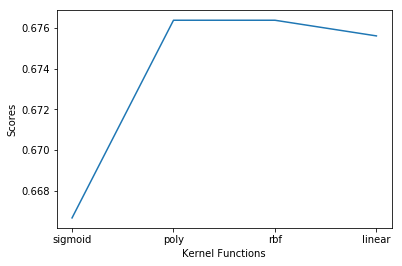

In [29]:
#Plotting kernel_functions vs scores
plt.plot(kernel_functions, scores)
plt.xlabel("Kernel Functions")
plt.ylabel("Scores")
plt.show()

### Poly Function provides best score according to the plot so we choose Poly Function as Kernel Function

In [30]:
#Model with best accuracy
svm_m2 = SVC(gamma = 'auto', kernel = 'poly', random_state = 42)
svm_m2.fit(x_train, y_train)
y_head = svm_m.predict(x_test)
print("SVM Best F1 Score: ",f1_score(y_test, y_head, average = 'weighted'))
print("SVM Best Jaccard Score: ",jaccard_similarity_score(y_test, y_head))

SVM Best F1 Score:  0.6756135445790618
SVM Best Jaccard Score:  0.6714285714285714


# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
regularization_val = [0.1, 0.01, 0.001]

index = []
ac_scores = []
iterations = 0

for index1,reg_val in enumerate(regularization_val):
    for index2, solver in enumerate(solvers):
        index.append(index1 + index2*5)
        log_reg = LogisticRegression(C = reg_val, solver = solver)
        log_reg.fit(x_train, y_train)
        y_proba = log_reg.predict_proba(x_test)
        ac_scores.append(log_loss(y_test, y_proba))
        iterations += 1
        print('Test {}: Accuracy at C = {} when Solver =  {}  is : {}'.format(iterations, reg_val, solver, log_loss(y_test, y_proba) ))
    print('\n')

Test 1: Accuracy at C = 0.1 when Solver =  lbfgs  is : 0.4906009552102404
Test 2: Accuracy at C = 0.1 when Solver =  saga  is : 0.49060000881697946
Test 3: Accuracy at C = 0.1 when Solver =  liblinear  is : 0.5079389073736977
Test 4: Accuracy at C = 0.1 when Solver =  newton-cg  is : 0.4906005621486958
Test 5: Accuracy at C = 0.1 when Solver =  sag  is : 0.4905975215520698


Test 6: Accuracy at C = 0.01 when Solver =  lbfgs  is : 0.4843617195402748
Test 7: Accuracy at C = 0.01 when Solver =  saga  is : 0.4843568395786147
Test 8: Accuracy at C = 0.01 when Solver =  liblinear  is : 0.5773412252583207
Test 9: Accuracy at C = 0.01 when Solver =  newton-cg  is : 0.48436179869413565
Test 10: Accuracy at C = 0.01 when Solver =  sag  is : 0.4843585813066881


Test 11: Accuracy at C = 0.001 when Solver =  lbfgs  is : 0.5049366335963562
Test 12: Accuracy at C = 0.001 when Solver =  saga  is : 0.5049394313430113
Test 13: Accuracy at C = 0.001 when Solver =  liblinear  is : 0.6703639392848284
Test

Max Score :  0.6703639392848284


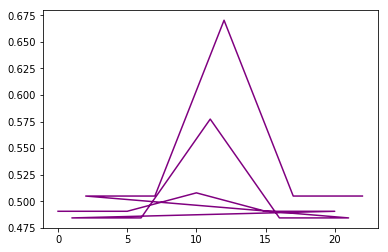

In [32]:
plt.plot(index, ac_scores,color = 'purple', label = 'regularization values')
print("Max Score : ",np.max((ac_scores)))

### Max log_loss score is 0.6703639392848284 when C = 0.001 and Solver =  liblinear

In [34]:
#Model with best accuracy
log_reg2 = LogisticRegression(C = 0.001, solver = 'liblinear')
log_reg2.fit(x_train, y_train)
y_head = log_reg2.predict(x_test)
y_proba = log_reg2.predict_proba(x_test)
print("Logistic Regression Best F1 Score : ", f1_score(y_test, y_head, average = 'weighted'))
print("Logistic Regression Best Jaccard Score : ", jaccard_similarity_score(y_test, y_head))
print("Logistic Regression Best log_loss Score : ", log_loss(y_test, y_proba))

Logistic Regression Best F1 Score :  0.695771878072763
Logistic Regression Best Jaccard Score :  0.7
Logistic Regression Best log_loss Score :  0.6703639392848284


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-12 15:15:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-12 15:15:43 (424 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [38]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)

# Testing feature
x_loan_test = test_feature

# Normalizing Test Data
x_loan_test = preprocessing.StandardScaler().fit(x_loan_test).transform(x_loan_test)

# Target result
y_loan_test = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:16: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [39]:
# Jaccard

# KNN
y_predKNN = knn2.predict(x_loan_test)
j1 = round(jaccard_similarity_score(y_loan_test, y_predKNN), 2)

# Decision Tree
y_predDT = dtc.predict(x_loan_test)
j2 = round(jaccard_similarity_score(y_loan_test, y_predDT), 2)

#SVM
y_predSVM = svm_m2.predict(x_loan_test)
j3 = round(jaccard_similarity_score(y_loan_test, y_predSVM), 2)

#Logistic Regression
y_predLR = log_reg2.predict(x_loan_test)
j4 = round(jaccard_similarity_score(y_loan_test, y_predLR), 2)

j_list = [j1, j2, j3, j4]
j_list

[0.67, 0.74, 0.78, 0.78]

In [44]:
# F1 Score

# KNN
y_predKNN = knn2.predict(x_loan_test)
f1 = round(f1_score(y_loan_test, y_predKNN, average = 'weighted'), 2)

# Decision Tree
y_predDT = dtc.predict(x_loan_test)
f2 = round(f1_score(y_loan_test, y_predDT, average = 'weighted'), 2)

#SVM
y_predSVM = svm_m2.predict(x_loan_test)
f3 = round(f1_score(y_loan_test, y_predSVM, average = 'weighted'), 2)

#Logistic Regression
y_predLR = log_reg2.predict(x_loan_test)
f4 = round(f1_score(y_loan_test, y_predLR, average = 'weighted'), 2)

f_list = [f1, f2, f3, f4]
f_list

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.62, 0.63, 0.74, 0.74]

In [41]:
# Log Loss
y_probaLR = log_reg2.predict_proba(x_loan_test)
ll_list = ['NA', 'NA', 'NA', round(log_loss(y_loan_test, y_probaLR, ),2)]
ll_list

['NA', 'NA', 'NA', 0.67]

In [42]:
# Making dictionary of lists then turn dictionary into dataframe
Algorithm = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']
d = {'Algorithm': Algorithm, 'Jaccard': j_list, 'F1-score': f_list, 'LogLoss': ll_list}

result_df = pd.concat([pd.Series(v, name=k) for k, v in d.items()], axis=1, ignore_index = False)
result_df.style.hide_index()

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.67,0.62,NA
Decision Tree,0.74,0.63,NA
SVM,0.78,0.74,NA
LogisticRegression,0.78,0.74,0.67


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>